In [63]:
import os

import pandas as pd
from pycountry import countries

# Paths
PATH_TO_DATA = "../data"

dfs = {}


def show_stat(df):
    display(df.head())
    df.info()
    df.describe()
    print("Sum of Nan values-------------------------------------------------")
    print(df.isna().sum())
    print("Shape of the csv",df.shape)

def filter_real_countries(df):
    valid_country_codes = {c.alpha_3 for c in countries}
    for col in ["country_code", "countrycode"]:
        if col in df.columns:
            df = df[df[col].isin(valid_country_codes)]
            break 
    return df


files = [files for _, _, files in os.walk(PATH_TO_DATA, topdown=False)][0]

for file in files:
    name = os.path.splitext(file)[0]
    df =pd.read_csv(os.path.join(PATH_TO_DATA, file))
    # Stock the dataframes in the dict
    dfs[name] = df
    # Display informations about the csvs
    print(f"-------------------------{file}---------------------------------")
    #show_stat(df)

-------------------------EdStatsData.csv---------------------------------
-------------------------EdStatsCountry.csv---------------------------------
-------------------------EdStatsSeries.csv---------------------------------
-------------------------EdStatsCountry-Series.csv---------------------------------
-------------------------EdStatsFootNote.csv---------------------------------


In [64]:
# Data cleaning
for name, df in dfs.items():
    # Remove duplicates
    nb_duplicates = df.duplicated().sum()
    if nb_duplicates > 0:
        df = df.drop_duplicates()
        print(f"Removed {nb_duplicates} duplicates.")
    
    # Drop completely empty columns
    empty_cols = df.columns[df.isna().sum() == len(df)]
    if len(empty_cols) > 0:
        print(f"Dropped empty columns: {list(empty_cols)}")
        df = df.drop(columns=empty_cols)
    # Make colons names homogeneous
    df.columns = (
        df.columns
        .str.strip()           
        .str.lower()            
        .str.replace(" ", "_")
    )
    df = filter_real_countries(df)
    # Store the cleaned dataframe
    dfs[name] = df
    print(10*'-', name)
    #show_stat(df)
    

Dropped empty columns: ['Unnamed: 69']
---------- EdStatsData
Dropped empty columns: ['Unnamed: 31']
---------- EdStatsCountry
Dropped empty columns: ['Unit of measure', 'Notes from original source', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20']
---------- EdStatsSeries
Dropped empty columns: ['Unnamed: 3']
---------- EdStatsCountry-Series
Dropped empty columns: ['Unnamed: 4']
---------- EdStatsFootNote


In [65]:
#Reduction of the perimeter

#exploration of intresting indicators

topics = dfs["EdStatsSeries"]["topic"].unique()

print("Avant filtrage",len(dfs["EdStatsSeries"]))

# filtering based on education/school key words based on the end goal
edu_keywords = [
    "education", "attain", "attainment", "learn", "learning","teacher", 
    "teachers", "literacy", "tertiary", "secondary", "primary","school",
    "Communications", "purchasing power", "Health: Population: Dynamics"
]

# function to apply on the dataset to filter keywords
def topic_is_relevant(topic, keywords=edu_keywords):
    t = str(topic).lower()
    return any(k in t for k in keywords)

filter_topics_education = dfs["EdStatsSeries"]["topic"].apply(topic_is_relevant)

filtered_series = dfs["EdStatsSeries"][filter_topics_education]
indicators = filtered_series["series_code"].unique()
print(filtered_series["topic"].unique())
print("Après filtrage", len(filtered_series))

# filter the data based on the indicator
def filter_indicators(df, indicators):
    for col in ["indicator_code	", "seriescode", "series_code"]:
        if col in df.columns:
            df = df[df[col].isin(indicators)]
            break 
    return df

for name, df in dfs.items():
    df = filter_indicators(df,indicators)
    # Drop completely empty columns
    empty_cols = df.columns[df.isna().sum() == len(df)]
    dfs[name] = df
    print(10*'-', name)
    #show_stat(df)

#display(filtered_series)
# display(dfs["EdStatsData"])
# print("avant filtrage",len(dfs["EdStatsData"]))
# filtered_data = dfs["EdStatsData"][dfs["EdStatsData"]["indicator_code"].isin(indicators)]
# print("après filtrage",len(filtered_data))
# print(filtered_data)
#print(f"{word:=^30})

Avant filtrage 3665
['Attainment' 'Education Equality' 'Learning Outcomes'
 'Economic Policy & Debt: Purchasing power parity' 'Teachers'
 'Education Management Information Systems (SABER)'
 'School Health and School Feeding (SABER)'
 'School Autonomy and Accountability (SABER)' 'School Finance (SABER)'
 'Teachers (SABER)' 'Tertiary Education (SABER)' 'Literacy' 'Primary'
 'Secondary' 'Tertiary' 'Early Childhood Education' 'Pre-Primary'
 'Post-Secondary/Non-Tertiary']
Après filtrage 3224
---------- EdStatsData
---------- EdStatsCountry
---------- EdStatsSeries
---------- EdStatsCountry-Series
---------- EdStatsFootNote


In [66]:
# Creation of a dict with the series_code and the topics
series = dfs["EdStatsSeries"]
indicator_dict = (
    series[["series_code", "topic"]]
    .drop_duplicates()
    .set_index("series_code")["topic"]
    .to_dict()
)

In [67]:
from datetime import datetime
import numpy as np

data = dfs["EdStatsData"]
stat_country = dfs["EdStatsCountry"]

# Identifier les colonnes représentant des années
current_year = datetime.now().year
min_year_stat = current_year - 20
# Reflection is minimum tech needed for online courses
min_year_tech = min(stat_country["latest_industrial_data"][~np.isnan(stat_country["latest_industrial_data"])].astype(int).unique())

min_year = min_year_stat if min_year_stat>min_year_tech else min_year_tech

year_cols = [col for col in data.columns if col.isdigit() and min_year <= int(col) <= current_year]

data_indicatos = data.groupby("indicator_code")[year_cols].apply(lambda x: x.notnull().sum().sum())

# Afficher les indicateurs totalement vides
empty_indicators = data_indicatos[data_indicatos == 0].index
print("Nombre d'indicateurs vides :", len(empty_indicators))

print([indicator_dict[i] for i in empty_indicators])

data = data[~data["indicator_code"].isin(empty_indicators)]

Nombre d'indicateurs vides : 12
['Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes', 'Learning Outcomes']


,year,non_null_count,fill_rate_%
0,2005,175638,22.363015
1,2006,131828,16.784930
2,2007,128764,16.394808
3,2008,125850,16.023784
4,2009,133523,17.000745
5,2010,233557,29.737521
6,2011,137403,17.494764
7,2012,138407,17.622598
8,2013,128655,16.380929
9,2014,105502,13.432986


29.737520610648144


<Axes: title={'center': 'Taux de remplissage par année'}, xlabel='year'>

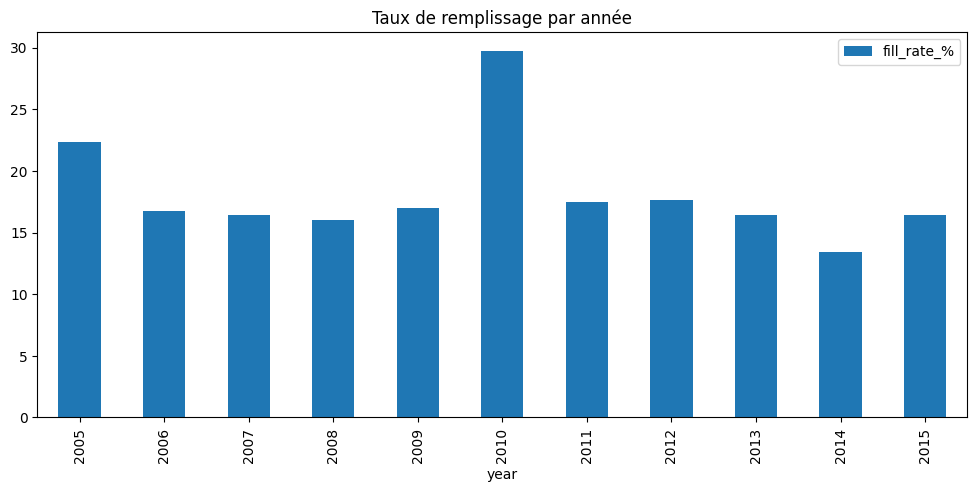

In [68]:
# Compter le nombre de valeurs non nulles par année
data_quality = data[year_cols].notnull().sum().reset_index()
data_quality.columns = ["year", "non_null_count"]
# Ajouter le pourcentage de remplissage
data_quality["fill_rate_%"] = 100 * data_quality["non_null_count"] / len(data)

# Trier et afficher
data_quality = data_quality.sort_values("year")
data_quality = data_quality[data_quality["fill_rate_%"] > 10]

display(data_quality)  # aperçu des dernières années
print(max(data_quality["fill_rate_%"]))
# Visualiser la tendance de complétude
data_quality.plot(x="year", y="fill_rate_%", kind="bar", figsize=(12,5), title="Taux de remplissage par année")

In [74]:
display(data)

,country_name,indicator_code,1970,1971,1972,1973,1974,1975,1976,1977,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
91625,Afghanistan,UIS.NERA.2,NaN,NaN,NaN,NaN,7.05911,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91626,Afghanistan,UIS.NERA.2.F,NaN,NaN,NaN,NaN,2.53138,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91627,Afghanistan,UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,0.22154,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91628,Afghanistan,UIS.NERA.2.M,NaN,NaN,NaN,NaN,11.42652,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91629,Afghanistan,SE.PRM.TENR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886925,Zimbabwe,UIS.LP.AG15T24.M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886926,Zimbabwe,SE.ADT.1524.LT.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886927,Zimbabwe,SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886928,Zimbabwe,SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:

# transposing my dataframe and have years as values
cols_to_keep = ["country_name","indicator_code"]+year_cols
data = data[cols_to_keep]
display(data)

# data_pivot = pd.pivot_table(data,
#     columns = ["indicator_code"],
#     index=["country_name", "country_code", "indicator_code"],  
#     values=year_cols,                                                                                       
#     aggfunc="mean")
# display(data_pivot)

,country_name,indicator_code,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025
91625,Afghanistan,UIS.NERA.2,NaN,NaN,28.059870,NaN,NaN,NaN,NaN,NaN,47.436790,50.627232,NaN,NaN,NaN,NaN,NaN
91626,Afghanistan,UIS.NERA.2.F,NaN,NaN,15.223100,NaN,NaN,NaN,NaN,NaN,34.073261,37.641541,NaN,NaN,NaN,NaN,NaN
91627,Afghanistan,UIS.NERA.2.GPI,NaN,NaN,0.379130,NaN,NaN,NaN,NaN,NaN,0.567060,0.598370,NaN,NaN,NaN,NaN,NaN
91628,Afghanistan,UIS.NERA.2.M,NaN,NaN,40.152851,NaN,NaN,NaN,NaN,NaN,60.087059,62.906952,NaN,NaN,NaN,NaN,NaN
91629,Afghanistan,SE.PRM.TENR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886925,Zimbabwe,UIS.LP.AG15T24.M,NaN,NaN,NaN,NaN,NaN,NaN,166679.00000,NaN,NaN,199464.000000,NaN,NaN,NaN,NaN,NaN
886926,Zimbabwe,SE.ADT.1524.LT.ZS,NaN,NaN,NaN,NaN,NaN,NaN,90.93070,NaN,NaN,90.428120,NaN,NaN,NaN,NaN,NaN
886927,Zimbabwe,SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,92.12456,NaN,NaN,93.188350,NaN,NaN,NaN,NaN,NaN
886928,Zimbabwe,SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,NaN,NaN,NaN,1.02828,NaN,NaN,1.063890,NaN,NaN,NaN,NaN,NaN
